# Pytorchを用いたCNNの実装

## 概要

機械学習用ライブラリPytorchを用いて、PythonでCNNを実装します。<br>
今回は、CIFAR-10を用いた10クラス認識のモデルを設計し、学習させます。


##  目次

1. データの準備
1. モデルの定義
1. モデルの学習
1. 学習記録のグラフ化
1. モデルのセーブ・ロード
1. モデルを用いたクラス認識予測デモ
1. モデルの中間出力の可視化

の順に実装します。

## データの準備
### 1. 1. ライブラリをインストールします。
- torchsummary
- tqdm

In [1]:
#pip install torchsummary
#pip install tqdm #conda install tqdmでも可

#pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
#pip install jupyterlab

### 1. 2. ライブラリをインポートします。
- pytorch(torch)
- torchvision
- numpy
- matplotlib
- PIL
- tqdm
- torchsummary
- pylab

In [2]:
import torch as torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchsummary import summary
from pylab import rcParams

C:\Users\student\.conda\envs\compe\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.3. データセット内の教師画像(PILImage)の下処理、変換を定義します。
- **torchvision.transforms**パッケージ内のクラスで行います。transforms.Composeでオブジェクトをまとめて返せます。  
- transfoms.処理一例
    - transforms.RandomHorizontalFlip(p=0.5), 50%で左右反転  
    - transforms.RandomVerticalFlip(p=0.5) 50%で上下反転  
    - transforms.RandomRotation(45) -45~45の範囲でランダムに回転  
    - transforms.ColorJitter(brightness=0.5) 明るさをランダムに0.5倍～1.5倍  
    - transforms.ToTensor()  PILImage -> Tensor, 0~1正規化  
- pytorchではデータをTensor形式で扱います。(listやnumpyと似たような構造を持つ)

In [3]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(), 
    ])

### 1.4. データセットのロード(画像(PILImage)と正解ラベルが格納されている))
- 有名なデータセットは**torchvision.datasets**クラス内で定義されており、簡単に利用できます。

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./dataset/',
                                             train=True, #訓練データをロード
                                             transform=transform,#上で定義した変換を適用
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./dataset/',
                                             train=False, #検証データをロード
                                             transform=transform,
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


### 1.5. データセット可視化用に画像(PILImage or Tensor)を壁画する関数を定義します。
- データセットの入力画像(PILImage)をtorchvision.transforms.ToTensor()でTensor型に変換したものを出力します
- 画像を表示するplt.imshow関数の引数の入力画像サイズは(H,W,C)なので(C,H,W)を**np.transpose(numpy,(並びの指定))**で(H,W,C)に変換します

In [5]:
%matplotlib inline
def show(img):
    npimg = img.numpy() 
    plt.grid(False) 
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

### 1.6. データセットの可視化

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear)
               ToTensor()
           )
学習画像サイズ torch.Size([3, 64, 64])
ラベル: 9


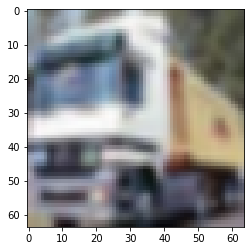

In [6]:
print (train_dataset)
image, label = train_dataset[1]
print("学習画像サイズ",image.size())
print ("ラベル:",label)
show(image)

### 1.7. データセットをミニバッチ単位に変換します。
- **torch.utils.data.DataLoader**クラスで行います。

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, #バッチあたり64枚
                                           shuffle=True,
                                          num_workers=4)#4プロセスでデータをロード
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32, 
                                           shuffle=False,
                                         num_workers=4)

## 2.モデルの定義
### 2.1. モデルの定義(nn.Moduleを継承したクラスでの書き方)
- **__init__**関数でネットワーク層の定義、初期化を行います。
- **forward**関数でモデルの入力→出力の定義、順伝搬の計算を行います。  
    - 定義したネットワーク層に入力(x)を伝搬していきます。
- 全結合ネットワークは**nn.Liner(入力パラメータ数、出力パラメータ数)**で定義します。
    - 画像データを扱う場合、入力パラメータ数は**二次元データを一次元に変換**して入力します。
    - Tensorのサイズ変換には**Tensor.view(軸について要素数を指定)**を用います。

In [8]:
num_classes = 10#出力クラス数

class AlexNet(nn.Module):
    
    #畳み込みブロック(プーリングなし)
    def conv_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            
        )
    #畳み込みブロック(プーリングあり)
    def conv_block_pooling(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
    
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        #畳み込みブロック群
        self.block1=self.conv_block(3,96)
        self.block2=self.conv_block_pooling(96,256)
        self.block3=self.conv_block(256,384)
        self.block4=self.conv_block_pooling(384,384)
        self.block5=self.conv_block(384,256)
        #全結合ブロック群
        self.classifier= nn.Sequential(
            #6ブロック(ここから全結合層)
            nn.Dropout(p=0.5),
            nn.Linear(256*32*32,1048),
            #7ブロック
            nn.Dropout(p=0.5),
            nn.Linear(1048,1048),
            #8ブロック(出力)
            nn.Linear(1048,num_classes),
        )

    def forward(self, x):
        #1-5ブロック
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        #(N,C,H,W)→(N,C*H*W)
        #print(x.size())
        x = x.view(x.size(0),256*32*32)
        #print(x.size())
        #6-8ブロック
        x = self.classifier(x)
        return x
    
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)#モデルをインスタンス


In [9]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MLP, self).__init__()#おまじない
        self.fc1=nn.Linear(3*64*64,1024)
        self.fc2=nn.Linear(1024,10)
      
    def forward(self, x):#ここで以前までの定義した関数を組み立てる
        #print(x.size())
        x = x.view(x.size(0),3*64*64)
        #print(x.size())
        x=self.fc1(x)
        x=self.fc2(x)
        return x

print(MLP())
net = MLP(num_classes).to(device)#モデルをインスタンス

MLP(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


### 2.2. モデルの可視化
- **summary(モデル,入力サイズ(チャンネル数、パラメータ数))**クラスで可視化を行います。

In [10]:
summary(net, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      12,583,936
            Linear-2                   [-1, 10]          10,250
Total params: 12,594,186
Trainable params: 12,594,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.01
Params size (MB): 48.04
Estimated Total Size (MB): 48.10
----------------------------------------------------------------


## 3. モデルの学習
### 3.1. 損失関数、最適化法(オプティマイザー)の定義
- 損失関数は**nn.CrossEntropyLoss()**(ソフトマックス+交差エントロピー)を用います。
- 最適化法には**optim.SGD(適用するモデルの重み、その他ハイパーパラメータの設定・・・)**を用います。

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

### 3.2. 学習の流れ(エポック単位)
- ①画像データと正解ラベルを取り出す
    - tqdmはjupyter内にプログレスバー(進行度)を表示する
- ②画像データとラベルデータ(共にバッチ単位)をデバイス(GPU)に移動
- ③勾配の初期化
- ④モデルの推測(画像データ→各クラスである確率)
- ⑤損失の計算
- ⑥⑤で求めた損失をエポックでの累計損失に加える
    - Tensorから値を取得する場合は、1次元(1要素)に指定してから.item()で取得する必要がある
- ⑦正答率の計算(出力の最大値のインデックスが正解ラベルの場合1を出力をバッチサイズ分行う(.sum())
    - (.maxは()で比較する値の軸を選び、[0]に最大値の値、[1]に最大値のインデックスを持つ)
- ⑧逆伝搬の計算
- ⑨勾配の更新<br>

---全バッチで行う---
- ⑩エポックでの平均誤差の計算
- ⑪エポックでの平均正答率の計算
- 検証データでの損失、精度を学習時と同じアルゴリズムで検証(逆伝搬、勾配の更新は行わない)

*1:学習時には.train()で学習に関連する機能を有効にします。   
*2:検証時には.eval()で学習に関連する機能を有効に、torch.no_grad()で自動微分を停止してから検証を行います。

In [27]:
num_epochs = 3 #学習エポックの設定

#グラフ作成のためにエポックごとの各値を保存する配列を作成
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

#学習の定義
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    i=0#学習回数
    
    net.train() #train *1
    for (images, labels) in tqdm(train_loader): #①
        images, labels = images.to(device), labels.to(device) #②
        optimizer.zero_grad() #③
        outputs = net(images) #④
        loss = criterion(outputs, labels)#⑤
        train_loss += loss.item()#⑥
        train_acc += (outputs.max(1)[1] == labels).sum().item() #⑦
        loss.backward()#⑧
        optimizer.step()#⑨
        
        
    
    avg_train_loss = train_loss / len(train_loader.dataset) #⑩
    avg_train_acc = train_acc / len(train_loader.dataset)   #⑪
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss,))
    #グラフ壁画用に各値を配列に格納
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)

100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:09<00:00, 159.20it/s]


Epoch [1/3], Loss: 0.0625


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:09<00:00, 160.13it/s]


Epoch [2/3], Loss: 0.0626


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:09<00:00, 160.26it/s]

Epoch [3/3], Loss: 0.0624


## 4. 学習記録のグラフ化
- matplotlibを用います。

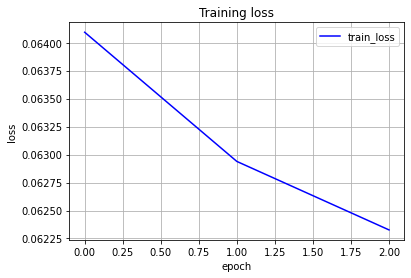

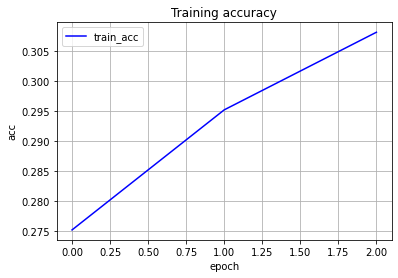

In [24]:
#学習のグラフ化
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training accuracy')
plt.grid()

## ここから下はコードを改変しないで

In [19]:
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(), 
    ])

dataset = torchvision.datasets.CIFAR10(root='./dataset/',
                                             train=False, #検証データをロード
                                             transform=transform,
                                             download=True)

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=32, 
                                           shuffle=False,
                                         num_workers=4)

Files already downloaded and verified


In [23]:
net.eval() #val *2
val_acc=0
with torch.no_grad():#自動微分停止 *2
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(data_loader.dataset)
    avg_val_acc = val_acc / len(data_loader.dataset)


print(avg_val_acc)


0.3319
